In [1]:
from simulation.model import PathFindingModel
import mesa
import analytics.ranking_measures as measures

In [2]:
import warnings
warnings.filterwarnings(action='once')

In [3]:
params = {"width":20,"height":20,"obs_num":40,"goals_num":[3,9,15],"goal_zone":[0,1,2,3,4,6,7,8,9],"seed":range(0,100),"path_planning_alg":[0,1,2]}
results = mesa.batch_run(
    PathFindingModel,
    parameters = params,
    iterations = 1,
    max_steps = 1000,
    number_processes = None,
    data_collection_period = 1,
    display_progress=True,
)

100%|██████████| 8100/8100 [4:07:56<00:00,  1.84s/it]   


In [4]:
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'obs_num', 'goals_num',
       'goal_zone', 'seed', 'path_planning_alg', 'Segment_ranking',
       'Masters_ranking', 'Mirroring_ranking'],
      dtype='object')


In [5]:
def df_transform(raw_df, measure_func):
    run_statistics = raw_df.groupby('RunId').agg(
        zone = pd.NamedAgg(column='goal_zone', aggfunc="first"),
        alg = pd.NamedAgg(column="path_planning_alg", aggfunc="first"),
        goal_pop = pd.NamedAgg(column="goals_num",aggfunc="first"),
        seed = pd.NamedAgg(column="seed",aggfunc="first"),
        segment_measure = pd.NamedAgg(column="Segment_ranking", aggfunc=measure_func),
        masters_measure = pd.NamedAgg(column="Masters_ranking", aggfunc=measure_func),
        mirroring_measure = pd.NamedAgg(column="Mirroring_ranking", aggfunc=measure_func)
    )
    run_statistics.set_index(['zone','goal_pop','seed','alg'], inplace=True)
    return run_statistics


In [6]:
def comparison_plot(measures_df,group_field,title,ax):
    tests_df = measures_df.copy()
    maximum = tests_df[["segment_measure","masters_measure","mirroring_measure"]].max(axis=1)
    minimum = tests_df[["segment_measure","masters_measure","mirroring_measure"]].min(axis=1)
    tests_df['superior'] = (tests_df["segment_measure"]==maximum) & (tests_df["segment_measure"]>minimum)
    tests_df['inferior'] = (tests_df["segment_measure"]==minimum) & (tests_df["segment_measure"]<maximum)
    tests_df['average'] = ~(tests_df['superior'] | tests_df['inferior'])
    group_statistics = tests_df.groupby(group_field).agg(superior=("superior","sum"),average=("average","sum"),inferior=("inferior","sum"))
    group_statistics = group_statistics.reset_index()
    return group_statistics.plot(
        x = group_field,
        kind= 'barh',
        stacked= True,
        title= title,
        mark_right=True,
        ax=ax
        )

### Stability: the frequency of ranking change 

In [7]:
run_df = df_transform(results_df,measures.stability)

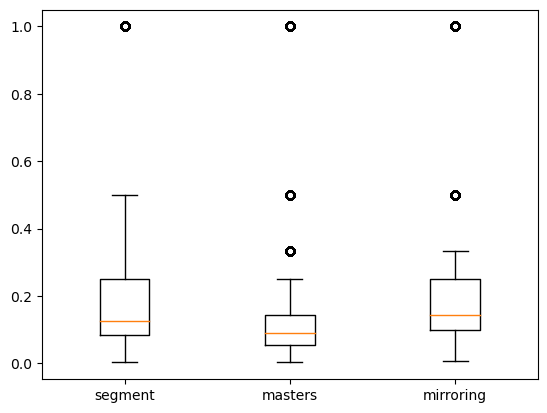

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.boxplot(run_df)
plt.xticks([1,2,3],['segment', 'masters','mirroring'])
plt.show()

#### Factor 1: obstacle/zones

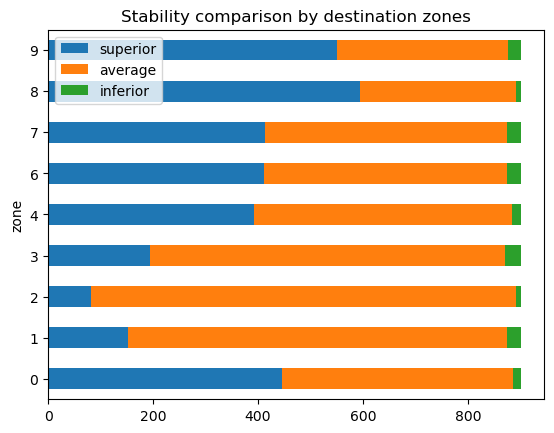

In [9]:
fig, axs = plt.subplots(1)
comparison_plot(run_df,'zone','Stability comparison by destination zones',axs)
plt.show()

#### Factor 2: Goal density
Group based on the number of goals, distinguishing zone 0, zone 2 and other zones

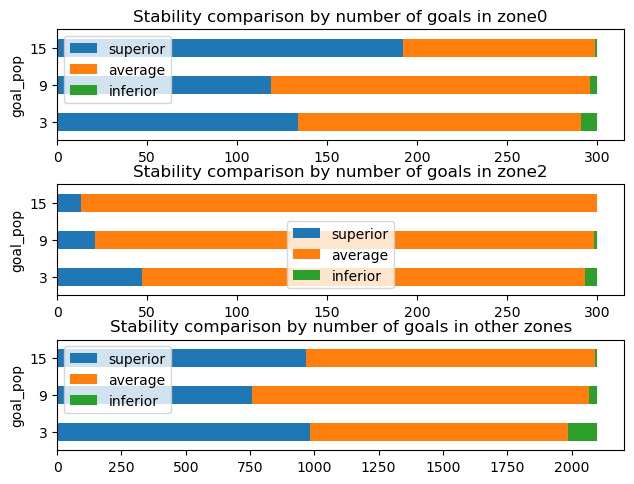

In [10]:
run_df = df_transform(results_df,measures.stability)
zone0 = run_df[run_df.index.get_level_values('zone').isin([0]) ]
zone2 = run_df[run_df.index.get_level_values('zone').isin([2])]
zone_other = run_df[run_df.index.get_level_values('zone').isin([1,3,4,5,6,7,8,9])]
fig,axs = plt.subplots(3)
fig.tight_layout()
comparison_plot(zone0,'goal_pop','Stability comparison by number of goals in zone0',axs[0])
comparison_plot(zone2,'goal_pop','Stability comparison by number of goals in zone2',axs[1])
comparison_plot(zone_other,'goal_pop','Stability comparison by number of goals in other zones',axs[2])
plt.show()

#### Factor 3: Movement types
compare different movement generation/path-finding algorithms

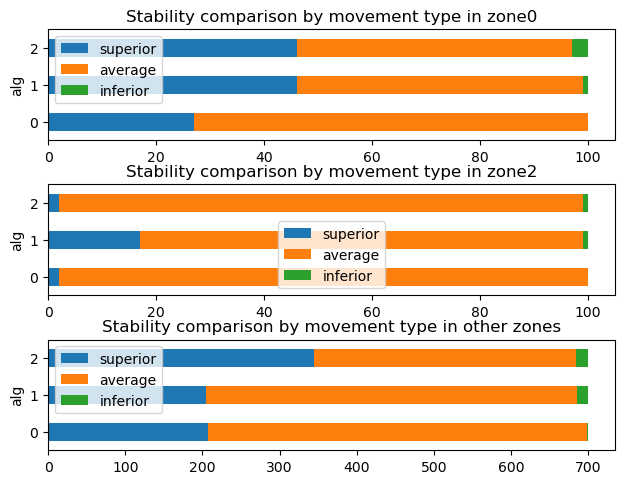

In [11]:
run_df = df_transform(results_df,measures.stability)
goal6 = run_df[run_df.index.get_level_values('goal_pop').isin([9]) ]
zone0 = goal6[goal6.index.get_level_values('zone').isin([0]) ]
zone2 = goal6[goal6.index.get_level_values('zone').isin([2])]
zone_other = goal6[goal6.index.get_level_values('zone').isin([1,3,4,5,6,7,8,9])]
fig,axs = plt.subplots(3)
fig.tight_layout()
comparison_plot(zone0,'alg','Stability comparison by movement type in zone0',axs[0])
comparison_plot(zone2,'alg','Stability comparison by movement type in zone2',axs[1])
comparison_plot(zone_other,'alg','Stability comparison by movement type in other zones',axs[2])
plt.show()

### Correctness: the proportion of time get the top ranked goal correct

In [12]:
run_df = df_transform(results_df,measures.correctness)

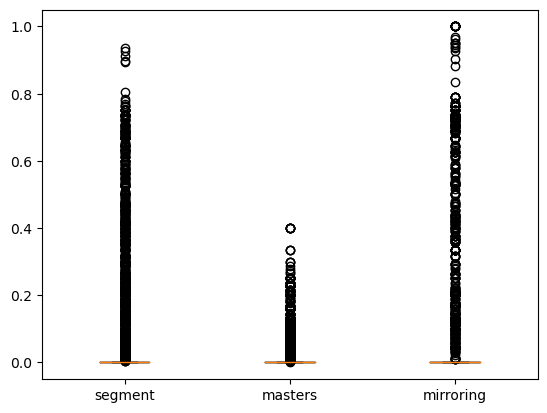

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.boxplot(run_df)
plt.xticks([1,2,3],['segment', 'masters', 'mirroring'])
plt.show()

#### Factor 1: obstacle/zones

<AxesSubplot: title={'center': 'Correctness comparison by destination zones'}, ylabel='zone'>

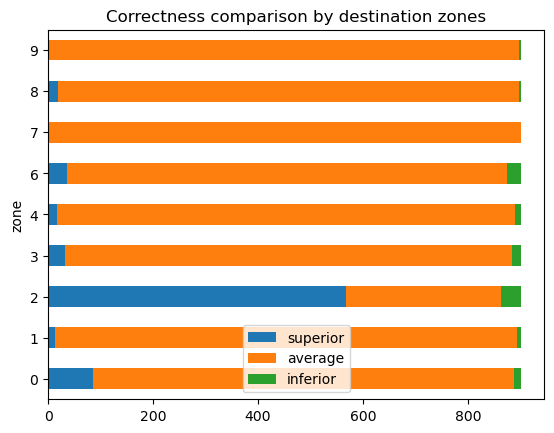

In [14]:
fig, axs = plt.subplots(1)
comparison_plot(run_df,'zone','Correctness comparison by destination zones',axs)

#### Factor 2: Goal density

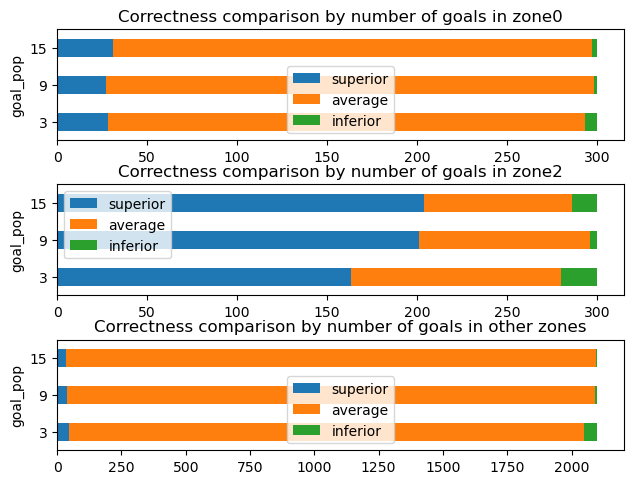

In [15]:
run_df = df_transform(results_df,measures.correctness)
zone0 = run_df[run_df.index.get_level_values('zone').isin([0]) ]
zone2 = run_df[run_df.index.get_level_values('zone').isin([2])]
zone_other = run_df[run_df.index.get_level_values('zone').isin([1,3,4,5,6,7,8,9])]
fig,axs = plt.subplots(3)
fig.tight_layout()
comparison_plot(zone0,'goal_pop','Correctness comparison by number of goals in zone0',axs[0])
comparison_plot(zone2,'goal_pop','Correctness comparison by number of goals in zone2',axs[1])
comparison_plot(zone_other,'goal_pop','Correctness comparison by number of goals in other zones',axs[2])
plt.show()

#### Factor 3: Movement types

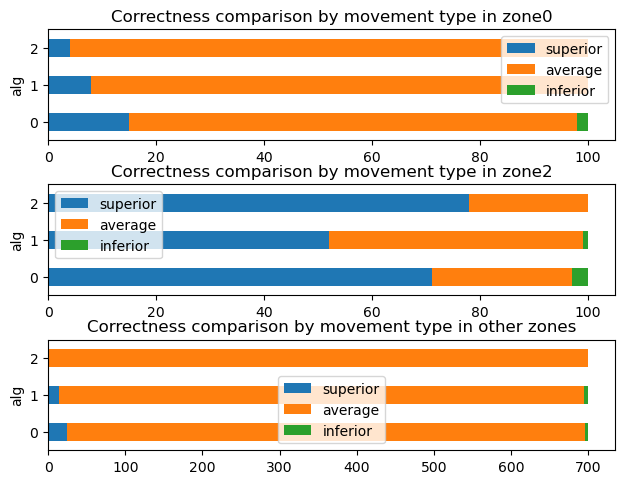

In [16]:
run_df = df_transform(results_df,measures.correctness)
goal6 = run_df[run_df.index.get_level_values('goal_pop').isin([9]) ]
zone0 = goal6[goal6.index.get_level_values('zone').isin([0]) ]
zone2 = goal6[goal6.index.get_level_values('zone').isin([2])]
zone_other = goal6[goal6.index.get_level_values('zone').isin([1,3,4,5,6,7,8,9])]
fig,axs = plt.subplots(3)
fig.tight_layout()
comparison_plot(zone0,'alg','Correctness comparison by movement type in zone0',axs[0])
comparison_plot(zone2,'alg','Correctness comparison by movement type in zone2',axs[1])
comparison_plot(zone_other,'alg','Correctness comparison by movement type in other zones',axs[2])
plt.show()

### Destination correctness
whether a prediction can get the destination correctness regardless of obstacle-related intension 

In [1]:
def local_correctness(rankings_list):
    return measures.correctness(rankings_list,margin=1)

In [2]:
run_df = df_transform(results_df,local_correctness)
fig,ax = plt.subplots()
ax.boxplot(run_df)
plt.xticks([1,2,3],['segment', 'masters', 'mirroring'])
plt.show()

NameError: name 'df_transform' is not defined

#### Factor 1: obstacle/zones

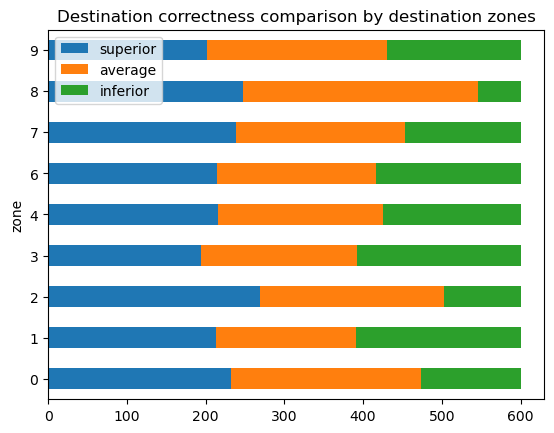

In [34]:
fig, axs = plt.subplots(1)
comparison_plot(run_df,'zone','Destination correctness comparison by destination zones',axs)
plt.show()

#### Factor 2: Goal desity

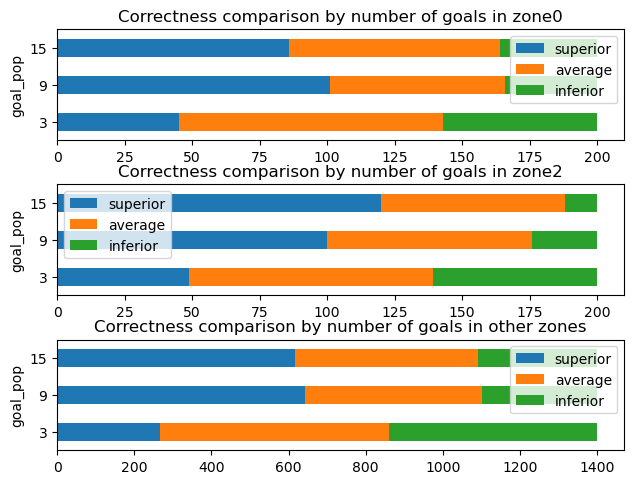

In [35]:
run_df = df_transform(results_df,local_correctness)
zone0 = run_df[run_df.index.get_level_values('zone').isin([0]) ]
zone2 = run_df[run_df.index.get_level_values('zone').isin([2])]
zone_other = run_df[run_df.index.get_level_values('zone').isin([1,3,4,5,6,7,8,9])]
fig,axs = plt.subplots(3)
fig.tight_layout()
comparison_plot(zone0,'goal_pop','Correctness comparison by number of goals in zone0',axs[0])
comparison_plot(zone2,'goal_pop','Correctness comparison by number of goals in zone2',axs[1])
comparison_plot(zone_other,'goal_pop','Correctness comparison by number of goals in other zones',axs[2])
plt.show()

#### Factor 3: Movement types

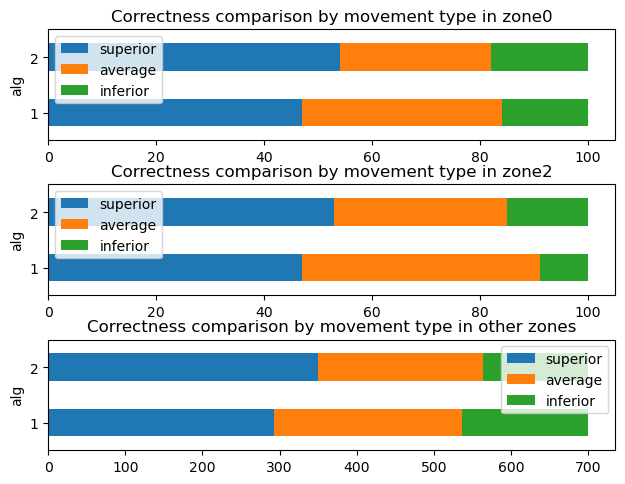

In [36]:
run_df = df_transform(results_df,local_correctness)
goal6 = run_df[run_df.index.get_level_values('goal_pop').isin([9]) ]
zone0 = goal6[goal6.index.get_level_values('zone').isin([0]) ]
zone2 = goal6[goal6.index.get_level_values('zone').isin([2])]
zone_other = goal6[goal6.index.get_level_values('zone').isin([1,3,4,5,6,7,8,9])]
fig,axs = plt.subplots(3)
fig.tight_layout()
comparison_plot(zone0,'alg','Correctness comparison by movement type in zone0',axs[0])
comparison_plot(zone2,'alg','Correctness comparison by movement type in zone2',axs[1])
comparison_plot(zone_other,'alg','Correctness comparison by movement type in other zones',axs[2])
plt.show()

## Evaluating correctness as progression 
Assumption: this assumes predition converges to the right answer as movment progress.

### Earliest correct prediction

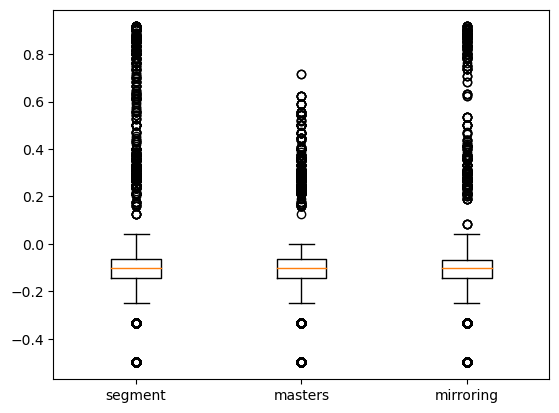

In [37]:
run_df = df_transform(results_df,measures.first_correct)
fig,ax = plt.subplots()
ax.boxplot(run_df)
plt.xticks([1,2,3],['segment', 'masters','mirroring'])
plt.show()

#### Factor 1: obstacle/zones

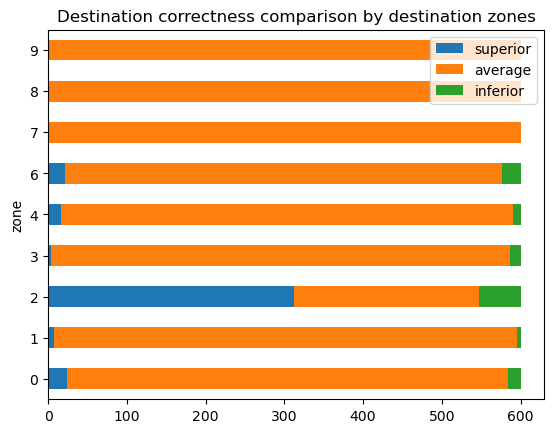

In [38]:
fig, axs = plt.subplots(1)
comparison_plot(run_df,'zone','Destination correctness comparison by destination zones',axs)
plt.show()

#### Factor 2: Goal density

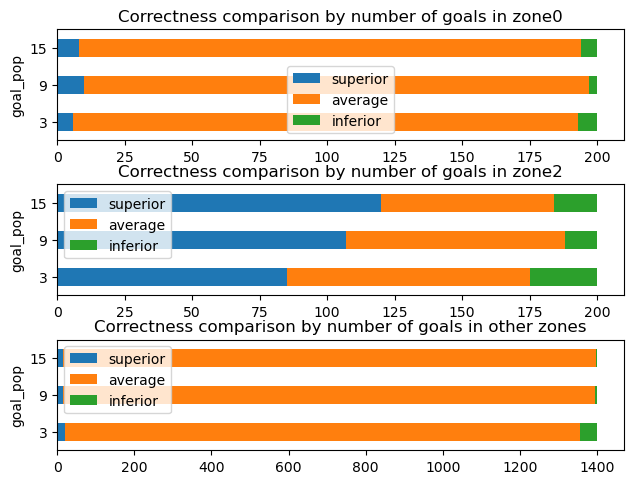

In [39]:
run_df = df_transform(results_df,measures.first_correct)
zone0 = run_df[run_df.index.get_level_values('zone').isin([0]) ]
zone2 = run_df[run_df.index.get_level_values('zone').isin([2])]
zone_other = run_df[run_df.index.get_level_values('zone').isin([1,3,4,5,6,7,8,9])]
fig,axs = plt.subplots(3)
fig.tight_layout()
comparison_plot(zone0,'goal_pop','Correctness comparison by number of goals in zone0',axs[0])
comparison_plot(zone2,'goal_pop','Correctness comparison by number of goals in zone2',axs[1])
comparison_plot(zone_other,'goal_pop','Correctness comparison by number of goals in other zones',axs[2])
plt.show()

#### Factor 3: Movement types

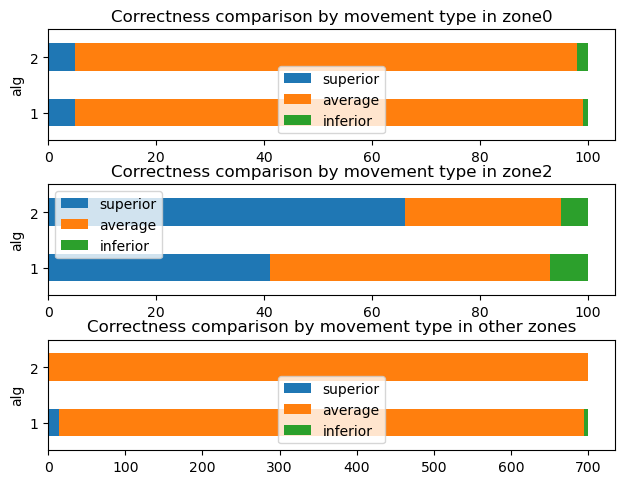

In [40]:
run_df = df_transform(results_df,measures.first_correct)
goal6 = run_df[run_df.index.get_level_values('goal_pop').isin([9]) ]
zone0 = goal6[goal6.index.get_level_values('zone').isin([0]) ]
zone2 = goal6[goal6.index.get_level_values('zone').isin([2])]
zone_other = goal6[goal6.index.get_level_values('zone').isin([1,3,4,5,6,7,8,9])]
fig,axs = plt.subplots(3)
fig.tight_layout()
comparison_plot(zone0,'alg','Correctness comparison by movement type in zone0',axs[0])
comparison_plot(zone2,'alg','Correctness comparison by movement type in zone2',axs[1])
comparison_plot(zone_other,'alg','Correctness comparison by movement type in other zones',axs[2])
plt.show()

### Convergece prediction correctness

In [21]:
import importlib
importlib.reload(measures)
prediction_first_correct = results_df.groupby("RunId")["Goal_Rank"].agg(measures.first_correct)
benchmark_first_correct = results_df.groupby("RunId")["Benchmark_Rank"].agg(measures.first_correct)
prediction_last_change = results_df.groupby('RunId')["Goal_Rank"].agg(measures.last_change)
benchmark_last_change = results_df.groupby('RunId')["Benchmark_Rank"].agg(measures.last_change)
correctness_df = pd.DataFrame({'zone':zones,'p_correct':prediction_first_correct,'b_correct':benchmark_first_correct,'p_change':prediction_last_change,'b_change':benchmark_last_change})


In [22]:
runs_of_interest = correctness_df[(correctness_df['p_correct']>0) & (correctness_df['b_correct']>0)]
superior = (runs_of_interest['p_change']<runs_of_interest['b_change'])
inferior = (runs_of_interest['p_change']>runs_of_interest['b_change'])
print(superior.sum())
print(inferior.sum())

13
33


## Predition on different type of movements
1. where we have the perfect global knowledge (use A* for path planning)
2. where the agent is only able to sense by bumping
3. where the agent plans based on local knowledge 

In [ ]:
prediction_stability = results_df.groupby("RunId")["Goal_Rank"].agg(measures.stability)
benchmark_stability = results_df.groupby("RunId")["Benchmark_Rank"].agg(measures.stability)
%matplotlib inline
import matplotlib.pyplot as plt
columns = [prediction_stability, benchmark_stability]
fig,ax = plt.subplots()
ax.boxplot(columns)
plt.xticks([1,2],['Prediction', 'Benchmark'])
plt.show()